In [1]:
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import gym

In [4]:
virtual_display = Display(visible=0, size=(1400, 900))
env = gym.make('LunarLander-v2')

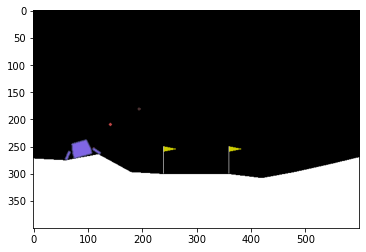

In [24]:
## random agent
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [10]:
class PolicyGradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [13]:
class PolicyGradientAgent():
    def __init__(self,network):
        self.network=network
        self.optimizer=optim.SGD(self.network.parameters(),lr=0.001)
    def learn(self,log_probs,rewards):
        # turn to DoubleTensor
        log_probs=log_probs.type(torch.DoubleTensor)
        rewards=rewards.type(torch.DoubleTensor)
        loss=(-log_probs*rewards).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def sample(self,state):
        action_prob=self.network(torch.FloatTensor(state))
        action_dist=Categorical(action_prob) # 按照传入的probs中给定的概率，在相应的位置处进行取样，取样返回的是该位置的整数索引。
        action=action_dist.sample()
        log_prob=action_dist.log_prob(action)
        return action.item(),log_prob

In [25]:
network=PolicyGradientNetwork()
agent=PolicyGradientAgent(network)

In [26]:
agent.network.train()
EPISODE_PER_BATCH = 5  
NUM_BATCH = 500

In [27]:
avg_total_rewards=[]
avg_final_rewards=[]
prg_bar = tqdm(range(NUM_BATCH))# 进度条
for bar in prg_bar:
    log_probs=[]
    rewards=[]# 同一个episode最后共享reward
    total_rewards=[]# 保存每个episode总共的reward
    final_rewards=[]# 保存每个episode最后一步的reward
    for episode in range(EPISODE_PER_BATCH):
        state=env.reset()
        total_reward,total_step=0,0
        while True:
            action,log_prob=agent.sample(state)
            next_state,reward,done,_=env.step(action)
            log_probs.append(log_prob)
            total_reward+=reward
            total_step+=1
            state=next_state
            
            # end of episode
            if done:
                total_rewards.append(total_reward)
                final_rewards.append(reward)
                # set reward the same for all actions in one episode
                rewards.append(np.full(total_step, total_reward))
                break
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")
    # update network
    rewards=np.concatenate(rewards,axis=0)
    rewards=(rewards-np.mean(rewards))/(np.std(rewards)+1e-9)
    agent.learn(torch.stack(log_probs),torch.from_numpy(rewards))

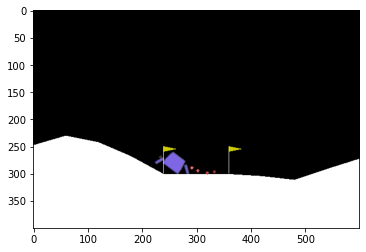

In [28]:
agent.network.eval()
state=env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
total_reward=0
done=False
while not done:
    action,_=agent.sample(state)
    new_state,reward,done,_=env.step(action)
    state=new_state
    total_reward+=reward
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [29]:
total_reward

-148.83765630428798